In [2]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [3]:
results_folder = "../optimization/results/v2/"

In [4]:
sage_walk = pd.read_csv(results_folder + "sage_walk_df.csv")
full_walk = pd.read_csv(results_folder + "sage_walk_full_df.csv")

In [ ]:
sage_walk.sort_values(by="val_auc", ascending=False).head()

,weight_decay,lr,epochs,patience,delta,feature_dim,features,pre_process_layers,post_process_layers,layer_connectivity,hidden_channels,batch_norm,dropout,macro_aggregation,L2_norm,msg_passing_layers,normalize_output,aggr,val_auc,accepted
4,0.001,0.010,400,10,0.1,32,random,1,1,False,64,False,0.0,sum,True,3,False,sum,0.934,True
948,0.001,0.001,300,10,0.1,32,random,2,1,cat,128,False,0.3,mean,True,4,False,sum,0.934,True
1001,0.001,0.010,500,10,0.1,32,random,1,1,sum,32,False,0.0,sum,True,3,False,sum,0.932,True
985,0.001,0.010,400,10,0.1,32,random,2,1,False,32,False,0.0,sum,True,3,False,sum,0.932,True
983,0.001,0.010,400,10,0.1,32,random,2,2,False,32,False,0.0,sum,True,3,False,sum,0.932,True


#### Distribucion de perfo para hps individuales - comparacion de caminatas

In [83]:
hps = [ 'feature_dim', 'pre_process_layers', 'post_process_layers',
       'layer_connectivity', 'hidden_channels', 'batch_norm', 'dropout',
        'L2_norm', 'msg_passing_layers', 'aggr']

In [9]:
gat_walk = pd.read_csv(results_folder+"gat_walk_df.csv")

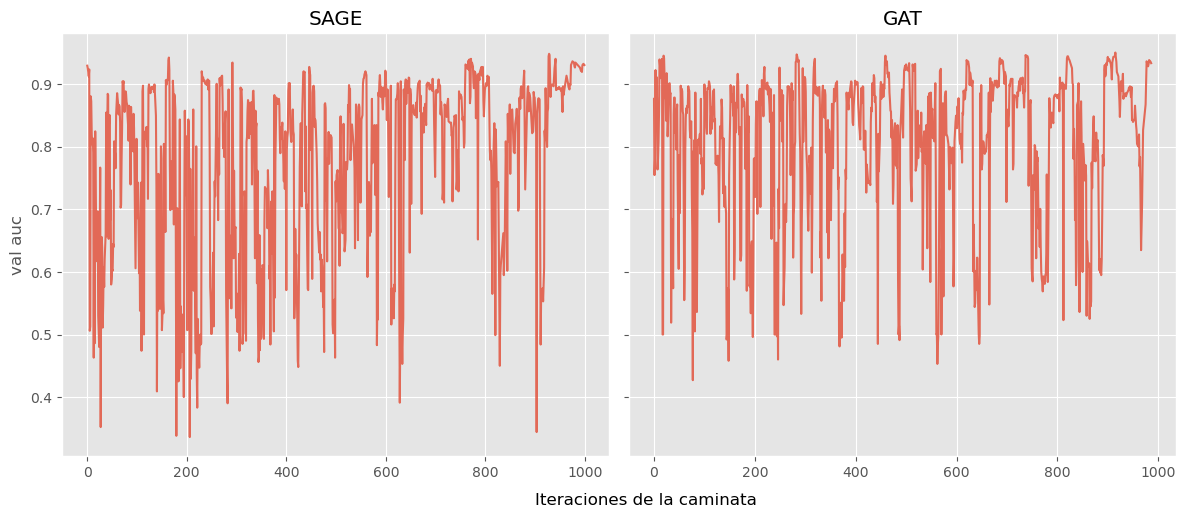

In [22]:
fig,axes = plt.subplots(1,2,figsize=(12,5),sharey=True)
axes[0].plot(full_walk[full_walk["accepted"]==True]["val_auc"], alpha=0.8)
axes[0].set_ylabel("val auc")
axes[0].set_title("SAGE")

axes[1].plot(gat_walk[gat_walk["accepted"]==True]["val_auc"], alpha=0.8)
axes[1].set_title("GAT")

fig.text(x=0.45, y=-0.02, s="Iteraciones de la caminata", fontsize=12)
plt.tight_layout()
plt.show()

Distribucion de perfo segun hiperparametro

Text(0.5, 1.0, 'Performance segun features utilizadas')

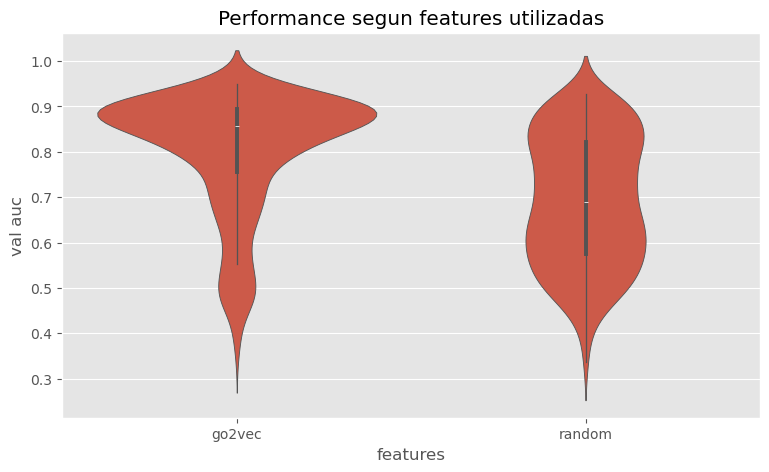

In [98]:
plt.figure(figsize=(9,5))
sns.violinplot(x="features", y="val_auc", data=full_walk)
plt.ylabel("val auc")
plt.title("Performance segun features utilizadas")

In [91]:
full_go2vec = full_walk[full_walk["features"] =="go2vec"]
full_rand = full_walk[full_walk["features"] =="random"]

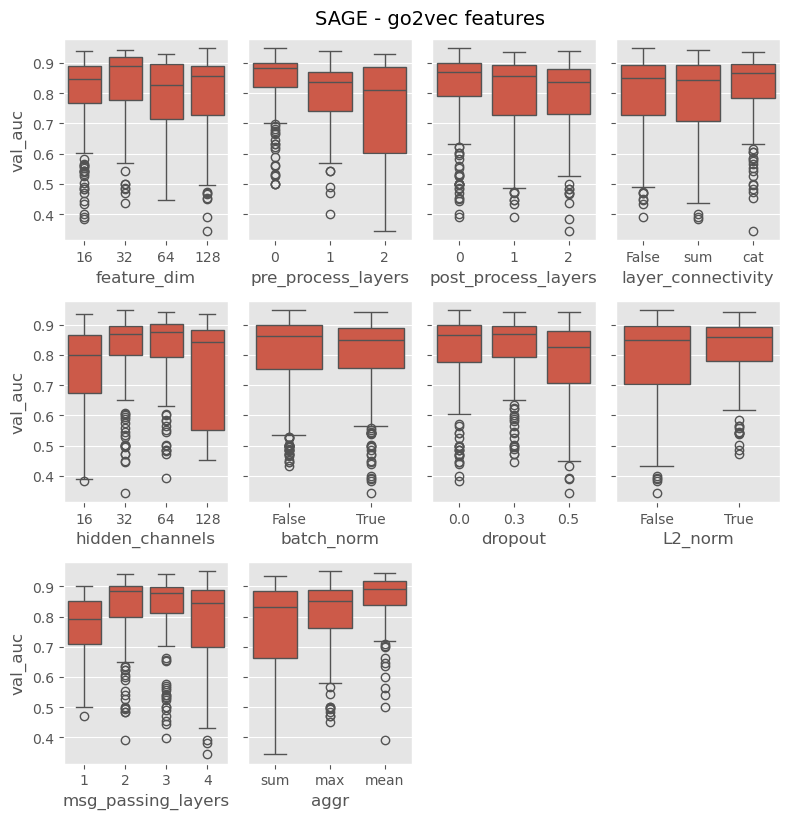

In [106]:
fig, axes = plt.subplots(3, 4, figsize=(8,8), sharey=True) 
for i in range(12):
    if i < 10:
        sns.boxplot(x=hps[i], y="val_auc", data=full_go2vec, ax=axes[i//4, i%4])
    else:
        axes[i//4, i%4].axis("off")

fig.text(x=0.4, y=1, s="SAGE - go2vec features", fontsize=14)
plt.tight_layout()
plt.show()

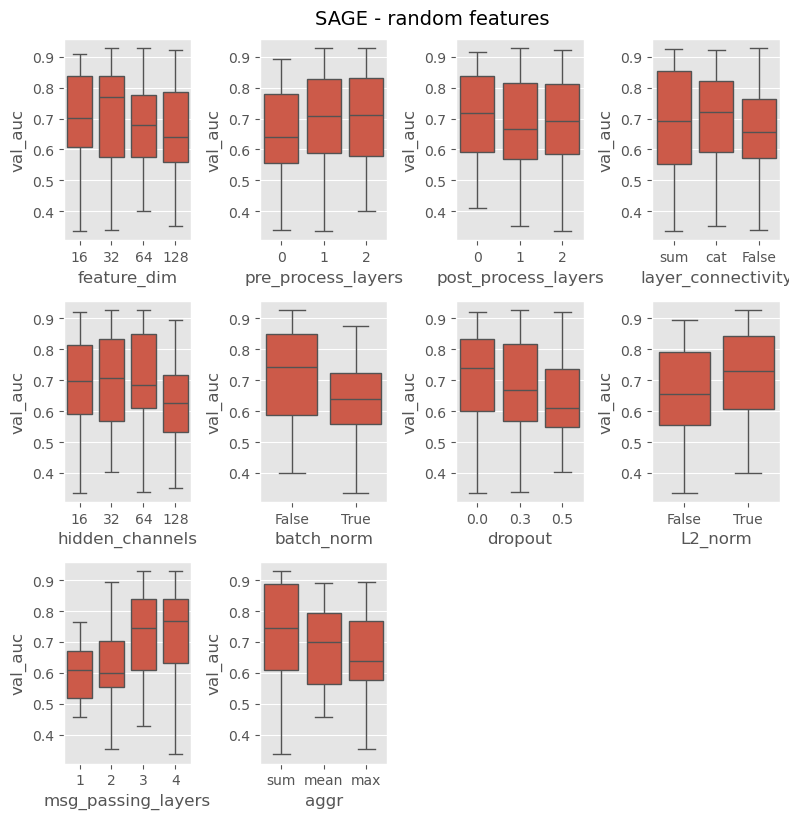

In [108]:
fig, axes = plt.subplots(3, 4, figsize=(8,8)) 
for i in range(12):
    if i < 10:
        sns.boxplot(x=hps[i], y="val_auc", data=full_rand, ax=axes[i//4, i%4])
    else:
        axes[i//4, i%4].axis("off")

fig.text(x=0.4, y=1, s="SAGE - random features", fontsize=14)
plt.tight_layout()
plt.show()

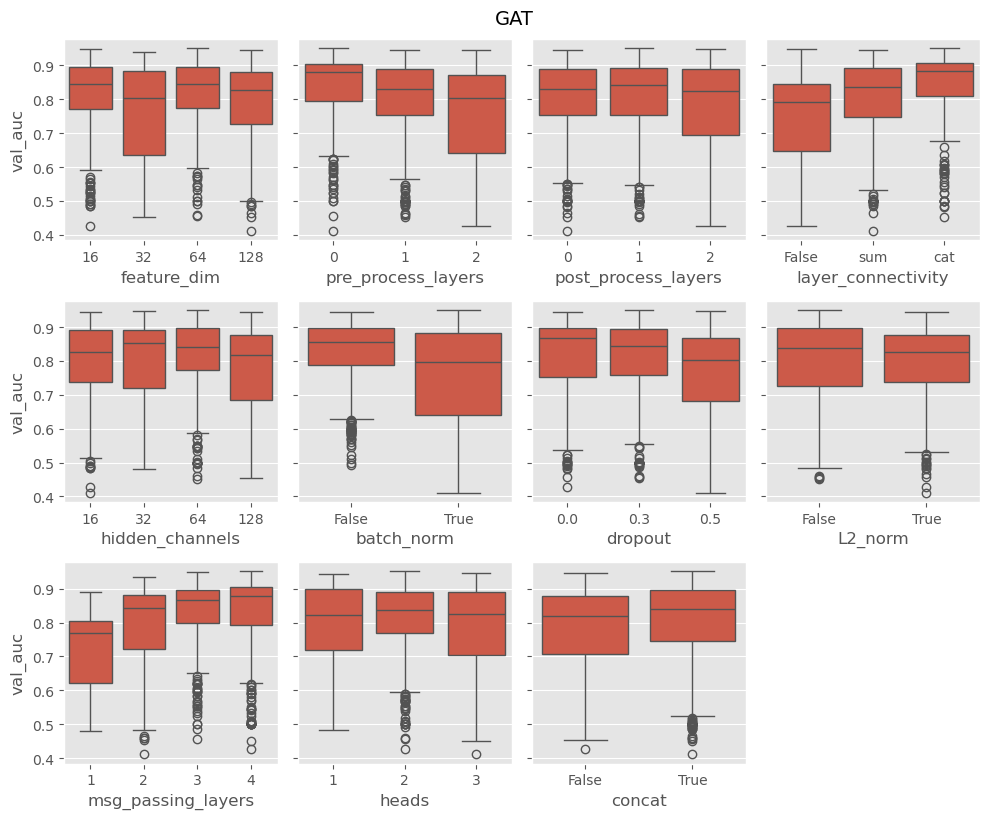

In [109]:
hps = ['feature_dim', 'pre_process_layers', 'post_process_layers',
       'layer_connectivity', 'hidden_channels', 'batch_norm', 'dropout',
       'L2_norm', 'msg_passing_layers', 'heads', "concat"]

fig, axes = plt.subplots(3, 4, figsize=(10,8), sharey=True) 
for i in range(12):
    if i<11:
        sns.boxplot(x=hps[i], y="val_auc", data=gat_walk, ax=axes[i//4, i%4])
    else:
        axes[i//4, i%4].axis("off")

fig.text(x=0.5, y=1, s="GAT", fontsize=14)
plt.tight_layout()
plt.show()

#### Grafico de auc vs distancia en hiperparametros

In [28]:
def hp_auc_dist(pair):
    row1, row2 = pair
    return sum(row1[:-2] != row2[:-2]), abs(row1["val_auc"]-row2["val_auc"])

In [29]:
import itertools
from concurrent.futures import ProcessPoolExecutor

def calculate_distances(df):
    pairs = list(itertools.combinations(df.iterrows(), 2))  # Generate all unique row pairs
    with ProcessPoolExecutor(max_workers=20) as executor:
        results = list(executor.map(hp_auc_dist, [(row1[1], row2[1]) for row1, row2 in pairs]))
    return results

In [30]:
results = calculate_distances(full_walk)

Text(0, 0.5, 'Diferencia de AUC')

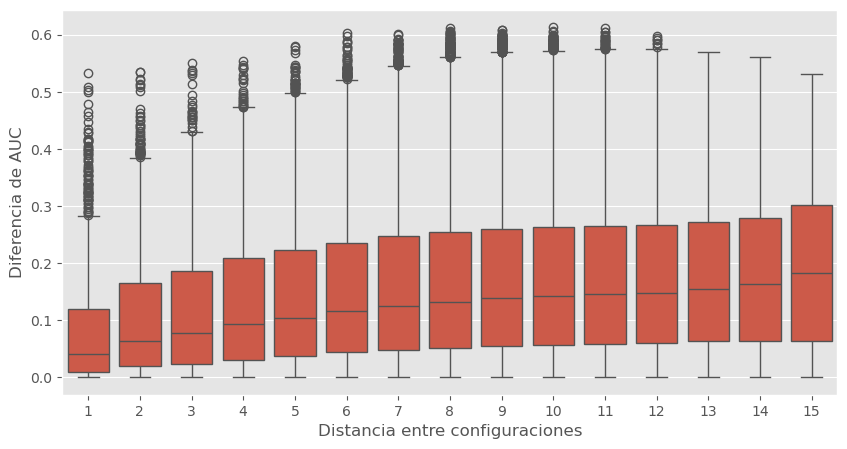

In [41]:
results = calculate_distances(full_walk)
plt.figure(figsize=(10,5))
df_results = pd.DataFrame(results, columns=["hp_dist", "auc_dif"])
df_results = df_results[df_results["hp_dist"]!=0]
sns.boxplot(x="hp_dist",y="auc_dif", data=df_results)
plt.xlabel("Distancia entre configuraciones")
plt.ylabel("Diferencia de AUC")

Text(0, 0.5, 'Diferencia de AUC')

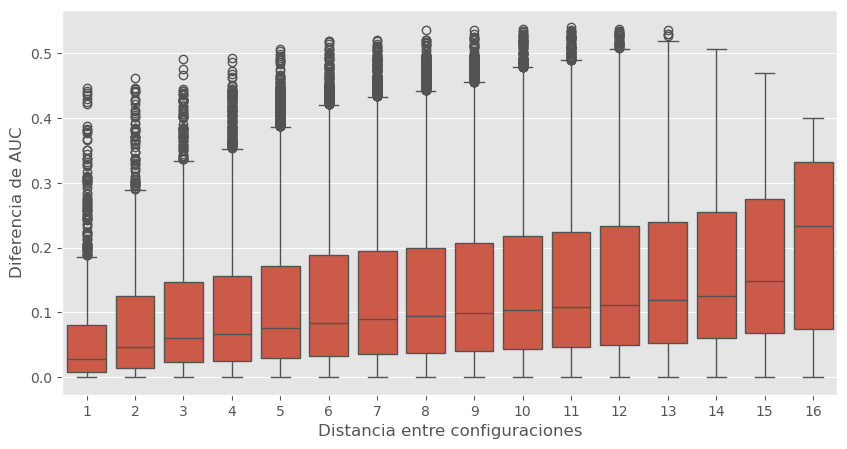

In [42]:
results = calculate_distances(gat_walk)
plt.figure(figsize=(10,5))
df_results_rand = pd.DataFrame(results, columns=["hp_dist", "auc_dif"])
df_results_rand = df_results_rand[df_results_rand["hp_dist"]!=0]
sns.boxplot(x="hp_dist",y="auc_dif", data=df_results_rand)
plt.xlabel("Distancia entre configuraciones")
plt.ylabel("Diferencia de AUC")

Vemos cambios puntuales en la caminata.

In [80]:
neg_changes = []
pos_changes = []
for i in range(1,gat_walk.shape[0]):
    diff = gat_walk.iloc[i]["val_auc"] - gat_walk.iloc[i-1]["val_auc"]
    if abs(diff) > 0.3:
        param = (gat_walk.iloc[i-1] != gat_walk.iloc[i]).idxmax()
        if param != "normalize_output":
            before_param, before_auc = gat_walk.iloc[i-1][param], gat_walk.iloc[i-1]["val_auc"]
            after_param, after_auc = gat_walk.iloc[i][param], gat_walk.iloc[i]["val_auc"]
            if diff < 0:
                neg_changes.append({param:(before_param, after_param, before_auc, after_auc)})
            else:
                pos_changes.append({param:(before_param, after_param, before_auc, after_auc)})

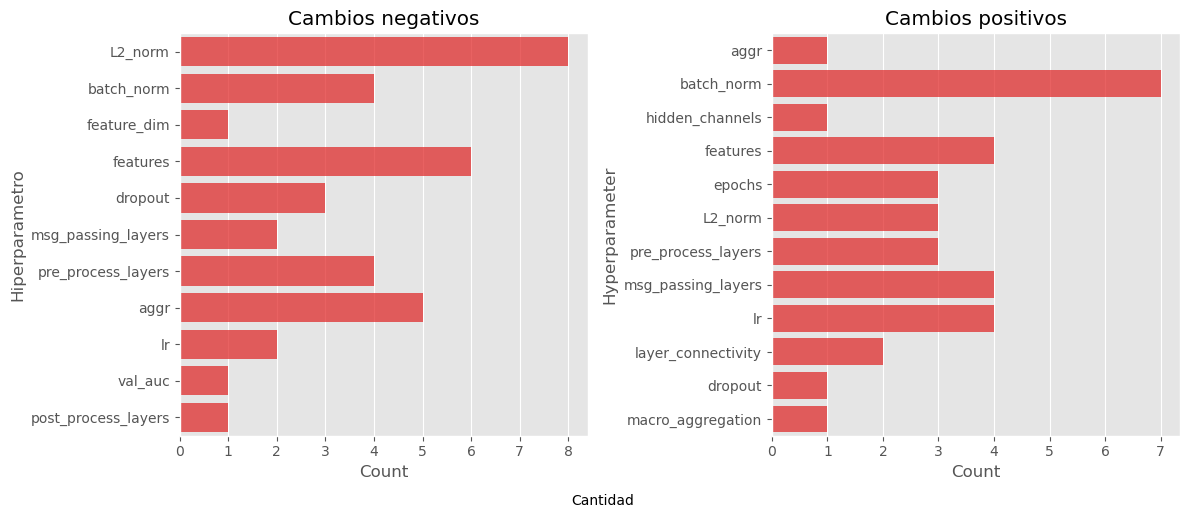

In [76]:
from collections import Counter
hyperparameter_counts_neg = Counter([list(x.keys())[0] for x in neg_changes])
hyperparameter_counts_pos = Counter([list(x.keys())[0] for x in pos_changes])


# Convert to DataFrame for plotting
data_neg = pd.DataFrame.from_dict(hyperparameter_counts_neg, orient='index').reset_index()
data_pos = pd.DataFrame.from_dict(hyperparameter_counts_pos, orient='index').reset_index()

data_neg.columns = ['Hyperparameter', 'Count']
data_pos.columns = ['Hyperparameter', 'Count']


fig, axes = plt.subplots(1,2,figsize=(12,5))

# Plot
sns.barplot(x='Count', y='Hyperparameter', data=data_neg, color="red",alpha=0.7,ax=axes[0])
sns.barplot(x='Count', y='Hyperparameter', data=data_pos, color="red",alpha=0.7,ax=axes[1])
axes[0].set_title("Cambios negativos")
axes[1].set_title("Cambios positivos")


plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.yticks(rotation=0, ha="right")  # Adjust y-axis labels for readability
fig.text(s='Cantidad',x=0.48, y=-0.02)
axes[0].set_ylabel('Hiperparametro')
plt.tight_layout()
plt.show()

In [77]:
from collections import defaultdict

def group_by_key(data):
    grouped_data = defaultdict(list)
    
    for item in data:
        for key, value in item.items():
            grouped_data[key].append(value)
    
    # Convert defaultdict back to a list of dictionaries
    result = [{key: value} for key, value in grouped_data.items()]
    return result

In [78]:
group_by_key(neg_changes)

[{'L2_norm': [(True, False, 0.924, 0.506),
   (True, False, 0.883, 0.559),
   (True, False, 0.853, 0.529),
   (True, False, 0.863, 0.399),
   (True, False, 0.844, 0.445),
   (True, False, 0.916, 0.459),
   (True, False, 0.891, 0.501),
   (True, False, 0.914, 0.502)]},
 {'batch_norm': [(False, True, 0.791, 0.463),
   (True, False, 0.844, 0.446),
   (True, False, 0.886, 0.576),
   (False, True, 0.926, 0.499)]},
 {'feature_dim': [(16, 128, 0.767, 0.352)]},
 {'features': [('go2vec', 'random', 0.736, 0.409),
   ('go2vec', 'random', 0.916, 0.554),
   ('go2vec', 'random', 0.898, 0.516),
   ('go2vec', 'random', 0.932, 0.58),
   ('go2vec', 'random', 0.935, 0.613),
   ('go2vec', 'random', 0.896, 0.557)]},
 {'dropout': [(0.0, 0.3, 0.641, 0.338),
   (0.3, 0.0, 0.739, 0.336),
   (0.3, 0.5, 0.809, 0.45)]},
 {'msg_passing_layers': [(4, 3, 0.765, 0.429), (4, 1, 0.912, 0.494)]},
 {'pre_process_layers': [(1, 2, 0.801, 0.438),
   (0, 2, 0.855, 0.501),
   (2, 0, 0.92, 0.609),
   (1, 2, 0.822, 0.344)]},
 {

In [79]:
group_by_key(pos_changes)

[{'aggr': [('mean', 'max', 0.486, 0.825)]},
 {'batch_norm': [(True, False, 0.578, 0.889),
   (False, True, 0.5, 0.823),
   (True, False, 0.554, 0.895),
   (True, False, 0.5, 0.905),
   (False, True, 0.499, 0.828),
   (False, True, 0.483, 0.878),
   (False, True, 0.576, 0.879)]},
 {'hidden_channels': [(64, 32, 0.338, 0.683)]},
 {'features': [('random', 'go2vec', 0.468, 0.86),
   ('go2vec', 'random', 0.445, 0.851),
   ('random', 'go2vec', 0.524, 0.887),
   ('random', 'go2vec', 0.58, 0.93)]},
 {'epochs': [(300, 500, 0.47, 0.801),
   (500, 400, 0.613, 0.929),
   (400, 300, 0.495, 0.809)]},
 {'L2_norm': [(False, True, 0.486, 0.921),
   (False, True, 0.39, 0.73),
   (False, True, 0.525, 0.892)]},
 {'pre_process_layers': [(2, 0, 0.542, 0.934),
   (2, 0, 0.472, 0.868),
   (2, 0, 0.501, 0.851)]},
 {'msg_passing_layers': [(1, 2, 0.505, 0.883),
   (1, 4, 0.493, 0.86),
   (1, 4, 0.494, 0.794),
   (4, 1, 0.5, 0.88)]},
 {'lr': [(0.0001, 0.001, 0.529, 0.92),
   (0.0001, 0.001, 0.399, 0.711),
   (0.01